In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Intro to Keras
- You'll find that our programming style is very similar to how Keras has implemented networks and training
- We'll introduce a number of keys concepts through examples
- As the course progresses new methods and api calls will be introduced
- We'll review the MNIST dataset and reconstruct our previously built networks using the Keras api

### Data: Pipeline
- Previously we saw how to download data using `keras`
- Our data pipeline will follow the steps:
    1. Download data
    2. Check size of data
    3. Convert numeric values to categories using one-hot-encoding
    4. Convert data to `float32`
    5. Reshape data 
    6. Rescale the data (so that the values are between 0 and 1)
- The aforementioned steps are common in most pre-processing steps before the data can be used
- As we move forward in the course a similar approach will be used with other datasets
- Note:
    - When saving a model's weights, `tf.keras defaults` to the checkpoint format
    - Pass `save_format='h5'` to use `HDF5`

/Users/kornraphop/.pyenv/versions/3.6.2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step
The number of training examples: (60000, 28, 28)
The number of test examples: (10000, 28, 28)


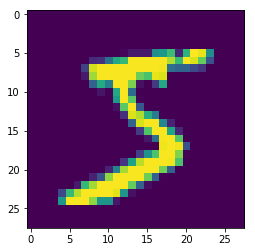

In [2]:
# --- Load data ---
from keras.datasets import mnist
from keras.utils import np_utils

# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# --- Checking size of MNIST Set ---
print("The number of training examples: "+str(X_train.shape))
print("The number of test examples: "+str(X_test.shape))

# --- Y_train to categorical ---
# Need to change these from numbers to categories
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

# --- Plotting data ---
from matplotlib import pyplot as plt
plt.imshow(X_train[0])

# --- Converting type and Normalize Values ---
n_train, l_train, w_train = X_train.shape
n_test, l_test, w_test = X_test.shape
X_train = X_train.astype('float32').reshape(n_train, l_train * w_train)
X_test = X_test.astype('float32').reshape(n_test, l_test * w_test)
X_train /= 255
X_test /= 255

# -- Split Train/Validation set --
n_val = 3000
X_val = X_train[:n_val,:]; X_train = X_train[n_val:,:]
Y_val = Y_train[:n_val,:]; Y_train = Y_train[n_val:,:]

### Build a simple model
- Keras has two ways to build models:
    1. Sequential - stacked layers
    2. Functional - multi input/output, recursive cells
- Over the next couple of sessions we'll use the sequential model
- The functional approach will come into play in the later parts of the session

#### Connecting networks
- Previously the input-output matrix shape needed to be specified for each layer 
- Being explicit about shapes is always a good idea since it forces you to think the architecture of the model
- `keras` however provides automatic shape inference 
- Only the first layer's shape needs to be specified, it can be done in several ways:
    - `input_shape` - tuple of integers
    - `input_dim` - for 2D layers
    - `input_dim`, `input_length` - for 3D temporal layers
    - *`batch_size` - may be included as an optional parameter with shape, i.e. `batch_size=32, input_shape=(6,8)`

In [3]:
# --- Import Librarires ----
import tensorflow as tf
from keras import Sequential
from keras.layers import Input, Dense
from keras.models import Model

# --- Setting up a Sigmoid Sequential Model ---
# Initialize model
model = Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(Dense(64, input_shape = (784,), activation='sigmoid'))
# Add another:
model.add(Dense(64, activation='sigmoid'))
# Add a softmax layer with 10 output units:
model.add(Dense(10, activation='softmax'))
# Check model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


### Plotting Networks


In [4]:
# --- Visualizing the model ----
# Note: pydot and graphviz required to run command
from keras.utils import plot_model
# -- Save model to file --
plot_model(model, 
           to_file='/home/joshuah/Desktop/github/guLectureNotes/model.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB') #'TB' = vertical plot, 'LR' = Horizontal plot

# -- Libraries for plotting inline --
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

### Configure the layers
- Different layer types are available along with common constructor parameters:
- Among the most important is `activation`:
    - `sigmoid`,`softmax`, `tanh`, `hard_sigmoid`
    - `relu`, `elu`,`selu`
    - `linear`
    - `softsign`, `softplus`
- Advanced activation layers such as `PReLu` and `LeakyReLu` are available through `keras.layers.advanced_activations`
- To read more vist the [Advanced Activation Layer](https://keras.io/layers/advanced-activations/) documentation

In [5]:
# --- Setting up a ReLu Sequential Model ---
model2 = Sequential()
model2.add(Dense(64,activation='relu', input_shape = (784,)))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


- Additional parameters when configuring layers include:    
    - `use_bias`: boolean indication if bias should be used
    - `kernel_initialize` and `bias_initialize`: initializes weight values `"Glorot uniform"` is the default
    - `kernel_regularizer` and `bias_regularizer`: regularization schemes applied to different layers
    - `kernel_constraint` and `bias_constraint` : construction applied to the kernel weights matrix and bias vector respectively

In [6]:
# --- Setting up a ReLu Sequential Model with Regularizers ---
from keras.regularizers import l1, l2
from keras.initializers import constant
# -- Model build --
model3 = Sequential()
# ReLu L1 regularization of factor 0.01 applied to the kernel matrix:
model3.add(Dense(64, 
                 activation = 'relu',
                 kernel_regularizer=l1(0.01),
                 input_shape = (451,)))

# ReLu with L2 regularization of factor 0.01 applied to the bias vector:
model3.add(Dense(64, bias_regularizer=l2(0.01)))
# Layer with a kernel initialized to a random orthogonal matrix:
model3.add(Dense(64, kernel_initializer='orthogonal'))
# Layer with a bias vector initialized to 2.0s:
model3.add(Dense(64, bias_initializer=constant(2.0)))
# Sigmoid output unit
model3.add(Dense(10, activation='softmax'))
# Model summary
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                28928     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 42,058
Trainable params: 42,058
Non-trainable params: 0
_________________________________________________________________


### Compiling a model
- Once the model is constructed it needs to be __compiled__
- Compiling a model means telling the computer to lazily evaluate:
    - The architecture
    - Optimization method
    - Number of batches
    - Metrics to follow
- Depending on the type of problem the appropriate parameters will need to be selected
- Inputs for the compilation method include:
    - `optimizer`: the type of optimization method used during training, common parameters include: `AdamOptimizer`, `RMSPropOptimizer`, `GradientDescentOptimizer`
    - ` loss`: function to minimize during optimization
        - `mse`: regression
        - `categorical_crossentropy`: multiclass-classificaation
        - `binary_crossentropy`: vanilla classification
    - `mae`: metrics used to monitor training

In [7]:
# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

- There might be times when you want to setup a __custom loss metric__:
```{python}
# --- For custom metrics ---
# Import keras backend
import keras.backend as K
# - Customer metric - 
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)
# Compile model with custom metric
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy', mean_pred])
```

- Setting the __optimization hyperparameters __ can also be done before compiling:
```
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
```
- There are many __Optimizers__ to choose from, read more at:
 * https://keras.io/optimizers/

### Training and evaluating
- Use the function `fit` to train the model
- Several options exist within the `fit` call:
    - `batch_size`: 
        - The model slices the data into smaller batches and iterates over these batches during training
        - This integer specifies the size of each batch
        - Recall smaller batch sizes occupy less memory and are closer to online gradient descent
    - `epochs` : number of times to iterate over the data
    - `shuffle`: shuffle the data
    - `validation_data`: validation set


In [8]:
# Train neural network
from time import time
start_time = time()
history_64 = model.fit(X_train, Y_train,
              batch_size=64, # Batch sizes - runtime scales ~linearly
              verbose = 1,
              epochs=3, 
              shuffle=False,
              validation_data=(X_val, Y_val))
time_to_complete = time()- start_time
print("Batch size 64: takes {} seconds to complete".format(time_to_complete))

Train on 57000 samples, validate on 3000 samples
Epoch 1/3
57000/57000 [==============================] - 2s 40us/step - loss: 0.6889 - acc: 0.8397 - val_loss: 0.2953 - val_acc: 0.9143
Epoch 2/3
57000/57000 [==============================] - 2s 34us/step - loss: 0.2552 - acc: 0.9258 - val_loss: 0.2182 - val_acc: 0.9343
Epoch 3/3
57000/57000 [==============================] - 2s 33us/step - loss: 0.1965 - acc: 0.9424 - val_loss: 0.1802 - val_acc: 0.9460
Batch size 64: takes 6.246483087539673 seconds to complete


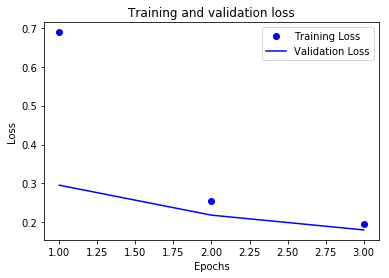

In [9]:
# --- Plotting data/training model ---
import matplotlib.pyplot as plt

# Get loss function
loss = history_64.history['loss']
val_loss = history_64.history['val_loss']

# Setup grid for plotting
epochs =range(1, len(loss) + 1)
# Plot
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluating model performance
- Several options exist for evaluate model performance
- We can predict the output values using:
    - `model.predict` and 
    - `model.predict_classes` - wrapper for model.predict for classes
- Alternatively we can use the `model.evaluate` function and score it's performance 

In [10]:
# --- Evaluation metrics ---
import numpy as np
# Evaluation metrics
score = model.evaluate(X_test, Y_test, batch_size=64)
predict_probabilities = model.predict(X_test, batch_size = 64)
predict_classes = model.predict_classes(X_test, batch_size = 64)

# -- Check to show predict and predict_classes are the same --
classes_from_probs =  np.argmax(predict_probabilities, axis = 1)
assert(np.alltrue(predict_classes == classes_from_probs))

10000/10000 [==============================] - 0s 18us/step


In [11]:
print(
"""
On the test set:
The mean validation loss is: {mean_test_loss},
The mean accuracy score is: {mean_test_accuracy}
The first 5 predict probabilites are: {pred_class}
""".format(mean_test_loss = score[0],
           mean_test_accuracy = score[1],
          pred_class = predict_classes[:5]))


On the test set:
The mean validation loss is: 0.1817934366106987,
The mean accuracy score is: 0.9459
The first 5 predict probabilites are: [7 2 1 0 4]



### Regularization and parameter tuning
- Previously we saw that L1/L2 regularization could easily be incorporated in the activation unit
- Other regularizers are added to the network slightly differently
- Below we present a network with dropout, custom RMSprop parameters and early stopping

In [12]:
# --- Setting up a ReLu Sequential Model with Dropout  ---
from keras.layers import Dropout
# Build model
model4 = Sequential()
model4.add(Dense(64,activation='relu', input_shape = (784,)))
model4.add(Dropout(0.2))
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(10, activation='softmax'))
model4.summary()

# --- Modifying training parameters ---
from keras.optimizers import RMSprop
opt = RMSprop(lr=0.0001, decay=1e-6)
model4.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

# --- Early stopping ---
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)
model4.fit(X_train, Y_train,
               batch_size=64, 
               epochs= 3,
               verbose = 0,
               validation_data=(X_val, Y_val),
               callbacks=[early_stopping_monitor])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                50240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


### Saving/reloading models
- Saving a model in `HDF5` format allows you to load
    - The architecture of the model, allowing to re-create the model
    - Weights
    - Training configuration (loss, optimizer)
    - State of the optimizer (you can resume training where you left off)
- To save a model in `HDF5` format you will need to install `h5py`
- Models can be saved by architecture and weight components in different formats (`YAML`, `json`)
- Componentizing this approach offers certain benefits:
    - Saving architecture's rather than all the weights frees up space
    - Saving only weights makes sense if you already have the model
    - Saving models in different formats allows you to port them to other `tensorflow` and `keras` ports/backends such as `tensorflow.js`

In [13]:
# --- Setting up directory --
import os
base_dir = os.getcwd()

# --- Saving full models in HDF5 Format ---
from keras.models import load_model
# Save model in HDF5 fomrat
model.save(os.path.join(base_dir,'my_model.h5')) 
# Deletes existing model
del model 

# --- Load model ---
# Returns a compiled model identical to the previous one
model = load_model(os.path.join(base_dir,'my_model.h5'))

In [14]:
# --- Saving only a models architecture ---
# Convert model to JSON
json_string = model.to_json()

# Convert model to YAML
yaml_string = model.to_yaml()

# --- Reconstructing model from different formats ---
from keras.models import model_from_json
from keras.models import model_from_yaml
# JSON model reload
model_json = model_from_json(json_string)
# YAML model load
model_yaml = model_from_yaml(yaml_string)

In [15]:
# --- Saving/Loading Model's Weights (only) ---
# Vanilla save/load
model.save_weights(os.path.join(base_dir,'my_model_weights.h5'))
model.load_weights(os.path.join(base_dir,'my_model_weights.h5'))

# --- Transfer learning approach to re-load ---
# When we load weights into a different 
# architeture with some common layers
model.load_weights(os.path.join(base_dir,'my_model_weights.h5'), 
                   by_name=True)


### Utility Functions
- There are many functions which we have not covered however this should be enough to get you started
- Some other utility functions include `shape`,`configuration` and `weights` which are applied to the model, see below for some examples:    

In [16]:
# --- Utility functions ---
print(model.output_shape)
print(model.get_config())
model.get_weights()
model.layers
model.layers[0].input_shape
model.layers[0].output_shape

(None, 10)
[{'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'batch_input_shape': (None, 784), 'dtype': 'float32', 'units': 64, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_2', 'trainable': True, 'units': 64, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None

(None, 64)

### Functional API
Most of the network architectures we will explore can be implemented with a sequential stack of layers. Indeed, all deep feedforward networks, convolutional networks, and recurrent networks are of this type. However, it might be the case that network architecture requires "branching" of data flows and layers. An example might be a multi-task network with a set of shared weights. To solve problems of this type, Keras has an entirely different API that is a bit more flexible. 

You may never need this kind of network, but you can read more about the Functional API here:

* https://keras.io/getting-started/functional-api-guide/

## Exercise 1 - MNIST
Load the MNIST image dataset. Use plt.imshow() to visualize a few of the images.

1. Build a simple linear classifier to predict which image class is represented in each image. This should be equivalent to multi-class logistic regression and this model will serve as our baselne.

2. Build a deeper network with ReLU activations.

3. Experiment with using different optimizers: read the documentation for `adam` and `rmsprop` to understand and modify their hyperparameters. 

4. Includer regularizers in different parts of your network. Use a train/test split to evaluate the imact of regularizers.

## Exercise 2 - Bullseye
Recall the Bullseye (or Donut) type of dataset: a binary classification problem where one of the classes entirely surrounds the other. The simplest version of this looks like the following.

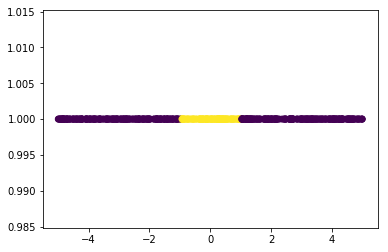

In [17]:
X = np.random.uniform(-5, 5, 500)
Y = np.zeros(len(X))
Y[(X<1) & (X>-1)] = 1
plt.scatter(X, np.ones(len(X)), c=Y)

#### Model Build
Build a network to solve this problem. What is the simplest network you can find that solves it? 

In [106]:
# --- Setting up a Sigmoid Sequential Model ---
# Initialize model
model = Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(Dense(16, input_shape = (1,), activation='relu'))
# Add another:
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(Dense(1, activation='sigmoid'))
# Check model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_68 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_69 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 5         
Total params: 377
Trainable params: 377
Non-trainable params: 0
_________________________________________________________________


In [107]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [112]:
model.fit(X, Y,
           batch_size=5, 
           epochs= 3,
           verbose = 0)

In [113]:
score = model.evaluate(X, Y, batch_size=1)
print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))

500/500 [==============================] - 0s 752us/step
Loss: 0.08602361287825261
Accuracy: 0.976


#### Visualization
We can examine the activations (or outputs) of any layer of a Keras model. For us, it will be useful to visualize the representation that our model has created in order to solve this problem. Recall, the dataset in the original 1-Dimensional space is not separable. So it is interesting to examine what new representation our network has learned so that the data classes become separable.



This utility allows us to create a function for extracting the outputs of any layer in a Keras model.

In [18]:
from keras import backend as K
def extract_layer_output(model, layer_num):
    return K.function([model.input] + [K.learning_phase()], [model.layers[layer_num].output])

Create a model with only a single hidden layer and only 2 nodes in that hidden layer. Fit this model has been fit to the data. When we pass an observation through this network (forward pass) we can think outputs of the hidden layer as a representation of the observation, but in a new coordinate system that our network has learned. 

Let's calculate the activations at the hidden layer.

In [19]:
H1 = extract_layer_output(model, 0) # layer 0 is the first hidden layer
H1_output = H1(X[:,np.newaxis]) # what is the shape of the output matrix here?

TypeError: `inputs` should be a list or tuple.

Make a visualization of the representation in the 2D hidden layer. Consider using a scatterplot and coloring each datapoint accoring to its class. Comment on this representation and why it allows us to solve the bullseye problem.

Repeat this process with the output layer. Make a visualization of X versus the final output Y, and color by class label.

## Exercise 3  - XOR
We'll revisit the Scattered XOR dataset. Build any network to solve this classification problem. 

In [ ]:
x = np.random.uniform(low=-2,high=2,size=1000).reshape((500,2))
y=np.zeros(500)
y[np.logical_and(x[:,0]>0 , x[:,1]>0)]=1
y[np.logical_and(x[:,0]<0 , x[:,1]<0)]=1

plt.scatter(x[:,0], x[:,1], c=y)

1. Experiment with networks of different capacity to try to find the "simplest" model that can solve this problem. 

2. Now do the opposite - build a deep and complex network to solve this problem. Which one seems easier to fit? 

3. Experiment with using different optimizers: read the documentation for `adam` and `rmsprop` to understand and modify their hyperparameters.